# Optimization Algorithm Evaluation

 * Evaluate the performance and cost optimization algorithm on a serverless application with 6 functions and 4 types of structures

In [1]:
import os
import logging
from io import BytesIO
import time
import zipfile
import numpy as np
import boto3
from datetime import datetime, timezone
from time import gmtime, strftime
import json
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle

## Performance Profile

In [2]:
App6_lambda_logs = pd.read_csv('App6_Lambda_Logs.csv', low_memory=False)
App6_lambda_logs.columns = ['Function', 'Memory_Size', 'Max_Memory_Used', 'Duration', 'Billed_Duration', 'RequestId']

In [3]:
App6_lambda_logs.head()

,Function,Memory_Size,Max_Memory_Used,Duration,Billed_Duration,RequestId
0,f1,3008,62,812.05,900,b6a380ea-ee12-457e-af63-6e3919bb1f2a
1,f1,3008,62,713.71,800,ff20d6e4-388f-4842-9d1e-c9aae94ca3fd
2,f1,3008,62,720.99,800,a6110dab-c8e7-491e-8075-6d46bb2ad026
3,f1,3008,62,711.73,800,56b4cb0a-4d1c-4912-8072-b3e0a634ec3a
4,f1,3008,62,798.65,800,175ce139-3afe-45a0-8101-db5870227043


In [4]:
viable_mem_list = list(range(128, 3072, 192))

In [5]:
performance_profile = {}
for i in range(6):
    dic = {}
    for mem in viable_mem_list:
        dic[mem] = np.array(
            App6_lambda_logs.query(f"Function == 'f{i + 1}' and Memory_Size == {mem} ")['Duration'].tolist()[10:190])
    performance_profile[f"f{i + 1}"] = dic

## Application Definition

In [6]:
import sys
sys.path.append('../../')
from slappsim.Structures import *
from slappsim.Function import Function
from slappsim.PetriApp import *
from slappsim.States import *
from slapptuner.AppTuner import AppTuner

In [7]:
from functools import partial

In [8]:
rs = np.random.RandomState(64)
random.seed(64)

In [9]:
def delay19():
    return 19.81
function_execution_delay_fun = partial(delay19)

In [10]:
delays = {'FunctionExecution': function_execution_delay_fun}

In [11]:
def dummy_fun():
    return 0
dummy_pf_fun = partial(dummy_fun)

* The equation for calculating the cost of functions has been changed to the old one.

In [12]:
start = Start()
end = End()
f1 = Function(pf_fun=dummy_pf_fun, mem=0, name='f1')
f2 = Function(pf_fun=dummy_pf_fun, mem=0, name='f2')
f3 = Function(pf_fun=dummy_pf_fun, mem=0, name='f3')
f4 = Function(pf_fun=dummy_pf_fun, mem=0, name='f4')
f5 = Function(pf_fun=dummy_pf_fun, mem=0, name='f5')
f6 = Function(pf_fun=dummy_pf_fun, mem=0, name='f6')
choice1 = Choice(choices=[f3, f5], probabilities=[0.8, 0.2])
parallel_sequence1 = Sequence(actions=[choice1])
parallel_sequence2 = Sequence(actions=[f2])
parallel1 = Parallel(branches=[parallel_sequence1, parallel_sequence2])
rchoice1 = Choice(choices=[f1, f4, f6], probabilities=[0.1, 0.2, 0.7], end=False)
sequence1 = Sequence(actions=[f1, parallel1, f4, rchoice1, f6])
structures = [parallel1, choice1, rchoice1, sequence1, parallel_sequence1, parallel_sequence2]
i1 = InArc(place=start)
o1 = OutArc(place=sequence1.structure_start)
t1 = Transition(in_arcs=[i1], out_arcs=[o1])
i2 = InArc(place=sequence1.structure_end)
o2 = OutArc(place=end)
t2 = Transition(in_arcs=[i2], out_arcs=[o2])
transitions = [t1, t2]
transitions += sequence1.transitions
app = PetriApp(transitions=transitions, functions=[f1, f2, f3, f4, f5, f6], structures=structures, delays=delays)


In [13]:
tuner_app = AppTuner(petri_model=app, performance_profile=performance_profile)

## Configure tasks

In [14]:
App6_BPBC_PRCP = pd.read_csv("App6_BPBC_PRCP.csv")
App6_BCPC_PRCP = pd.read_csv("App6_BCPC_PRCP.csv")

In [15]:
budget_constraint = App6_BPBC_PRCP['Budget'].to_list()
performance_constraint = App6_BCPC_PRCP['Performance_Constraint'].to_list()

## BPBC

In [ ]:
%%capture
os.mkdir("BPBC")
for constraint in budget_constraint:
    result = {}
    result['problem'] = 'BPBC'
    result['constraint'] = constraint
    result['percentile'] = None 
    configuration = tuner_app.optimize_bpbc(budget_constraint = constraint, percentile = None)
    result['optimized_configuration'] = configuration
    result['duration'] = tuner_app.ert_list.tolist()
    result['cost'] = tuner_app.cost_list.tolist()
    with open(f"./BPBC/{round(constraint, 2)}_avg.json", 'w') as f:
        json.dump(result, f)

## BCPC

In [ ]:
%%capture
os.mkdir("BCPC")
for constraint in performance_constraint:
    result = {}
    result['problem'] = 'BCPC'
    result['constraint'] = constraint
    result['percentile'] = None
    configuration = tuner_app.optimize_bcpc(performance_constraint = constraint, percentile = None)
    result['optimized_configuration'] = configuration
    result['duration'] = tuner_app.ert_list.tolist()
    result['cost'] = tuner_app.cost_list.tolist()
    with open(f"./BCPC/{round(constraint, 2)}_avg.json", 'w') as f:
        json.dump(result, f)

## Results

### DFBA

In [16]:
optimization_results = pd.DataFrame(columns=["problem", "constraint", "percentile", "optimized_configuration", "duration_avg", "duration_median", "duration_percentile10", "duration_percentile90", "cost_avg", "cost_median", "cost_percentile10", "cost_percentile90"])

In [17]:
for file in os.listdir("BPBC"):
    with open(f"BPBC/{file}" , "r") as f:
        result_dict = {}
        result = json.load(f)
        result["duration_avg"] = np.mean(result['duration'])
        result["duration_median"] = np.median(result['duration'])
        result["duration_percentile10"] = np.percentile(result['duration'], 10)
        result["duration_percentile90"] = np.percentile(result['duration'], 90)
        result["cost_avg"] = np.mean(result['cost']) * 1000000
        result["cost_median"] = np.median(result['cost']) * 1000000
        result["cost_percentile10"] = np.percentile(result['cost'], 10) * 1000000
        result["cost_percentile90"] = np.percentile(result['cost'], 90) * 1000000
        result.pop("duration")
        result.pop("cost")
        optimization_results = optimization_results.append(result, ignore_index=True)

In [18]:
for file in os.listdir("BCPC"):
    with open(f"BCPC/{file}" , "r") as f:
        result_dict = {}
        result = json.load(f)
        result["duration_avg"] = np.mean(result['duration'])
        result["duration_median"] = np.median(result['duration'])
        result["duration_percentile10"] = np.percentile(result['duration'], 10)
        result["duration_percentile90"] = np.percentile(result['duration'], 90)
        result["cost_avg"] = np.mean(result['cost']) * 1000000
        result["cost_median"] = np.median(result['cost']) * 1000000
        result["cost_percentile10"] = np.percentile(result['cost'], 10) * 1000000
        result["cost_percentile90"] = np.percentile(result['cost'], 90) * 1000000
        result.pop("duration")
        result.pop("cost")
        optimization_results = optimization_results.append(result, ignore_index=True)

In [19]:
optimization_results.head()

,problem,constraint,percentile,optimized_configuration,duration_avg,duration_median,duration_percentile10,duration_percentile90,cost_avg,cost_median,cost_percentile10,cost_percentile90
0,BPBC,145.767517,None,"{'f1': 1472, 'f2': 2240, 'f3': 2048, 'f4': 300...",2666.133869,2255.990,2042.770,3943.720,116.307133,95.1668,89.1252,172.1128
1,BPBC,76.887081,None,"{'f1': 896, 'f2': 1280, 'f3': 1664, 'f4': 1472...",3200.129564,2656.680,2552.858,4638.300,76.653540,62.6668,60.7918,110.9836
2,BPBC,91.237171,None,"{'f1': 1280, 'f2': 1280, 'f3': 1664, 'f4': 224...",2830.286739,2386.890,2249.861,4169.074,91.036377,75.1669,71.5210,133.9003
3,BPBC,149.594208,None,"{'f1': 1472, 'f2': 2240, 'f3': 2048, 'f4': 300...",2690.636497,2256.045,2042.399,3955.384,117.570038,95.2710,89.1252,173.2586
4,BPBC,74.017062,None,"{'f1': 896, 'f2': 1280, 'f3': 1664, 'f4': 1280...",3116.321378,2581.080,2489.470,4595.533,73.654462,61.7293,60.2710,106.6961


### PRCP

In [23]:
perf_cost_data = pd.DataFrame()
for file in os.listdir('Exhaustive_Search'):
    if '.csv' in file:
        data_parts = pd.read_csv(f"Exhaustive_Search/{file}")
        perf_cost_data = perf_cost_data.append(data_parts)

In [24]:
App6_BPBC_PRCP = App6_BPBC_PRCP.assign(Best_Answer_RT=lambda App6_BPBC_PRCP: App6_BPBC_PRCP[['BCR_disabled_RT', 'BCR_RT/M_RT', 'BCR_ERT/C_RT', 'BCR_MAX_RT']].min(1))
best_rt = [perf_cost_data.query("Cost<={}".format(item))['RT'].min() for item in App6_BPBC_PRCP['Budget']]

In [25]:
App6_BPBC_PRCP.head()

,Budget,BCR_disabled_RT,BCR_RT/M_RT,BCR_ERT/C_RT,BCR_MAX_RT,BCR_disabled_Cost,BCR_RT/M_Cost,BCR_ERT/C_Cost,BCR_MAX_Cost,BCR_disabled_Config,BCR_RT/M_Config,BCR_ERT/C_Config,BCR_MAX_Config,BCR_disabled_Iterations,BCR_RT/M_Iterations,BCR_ERT/C_Iterations,BCR_MAX_Iterations,BCR_threshold,Best_Answer_RT
0,59.666971,10868.5009,10868.5009,25433.083814,10868.500900,59.599543,59.599543,59.666971,59.599543,"{1: 896, 2: 896, 3: 1088, 4: 128, 5: 512, 6: 1...","{1: 896, 2: 896, 3: 1088, 4: 128, 5: 512, 6: 1...","{1: 128, 2: 128, 3: 128, 4: 128, 5: 128, 6: 128}","{1: 896, 2: 896, 3: 1088, 4: 128, 5: 512, 6: 1...",9.0,9.0,3.0,9.0,0.2,10868.500900
1,60.623644,10772.8808,10772.8808,13629.086743,11727.572671,60.328543,60.328543,60.447400,59.980800,"{1: 896, 2: 896, 3: 1088, 4: 128, 5: 512, 6: 1...","{1: 896, 2: 896, 3: 1088, 4: 128, 5: 512, 6: 1...","{1: 896, 2: 128, 3: 128, 4: 128, 5: 128, 6: 1856}","{1: 896, 2: 320, 3: 320, 4: 128, 5: 512, 6: 1472}",8.0,8.0,5.0,8.0,0.2,10772.880800
2,61.580317,10772.8808,10772.8808,13629.086743,11631.952571,60.328543,60.328543,60.447400,60.709800,"{1: 896, 2: 896, 3: 1088, 4: 128, 5: 512, 6: 1...","{1: 896, 2: 896, 3: 1088, 4: 128, 5: 512, 6: 1...","{1: 896, 2: 128, 3: 128, 4: 128, 5: 128, 6: 1856}","{1: 896, 2: 320, 3: 320, 4: 128, 5: 512, 6: 1856}",8.0,8.0,5.0,9.0,0.2,10772.880800
3,62.536990,10757.7975,10772.8808,13614.003443,6811.492243,61.893543,60.328543,62.012400,62.397943,"{1: 896, 2: 896, 3: 1088, 4: 128, 5: 512, 6: 2...","{1: 896, 2: 896, 3: 1088, 4: 128, 5: 512, 6: 1...","{1: 896, 2: 128, 3: 128, 4: 128, 5: 128, 6: 2048}","{1: 896, 2: 320, 3: 320, 4: 320, 5: 512, 6: 1472}",8.0,8.0,5.0,9.0,0.2,6811.492243
4,63.493662,10754.2255,10738.5096,13614.003443,6715.872143,63.458543,63.181114,62.012400,63.126943,"{1: 896, 2: 896, 3: 1088, 4: 128, 5: 512, 6: 2...","{1: 1088, 2: 896, 3: 1088, 4: 128, 5: 512, 6: ...","{1: 896, 2: 128, 3: 128, 4: 128, 5: 128, 6: 2048}","{1: 896, 2: 320, 3: 320, 4: 320, 5: 512, 6: 1856}",9.0,8.0,5.0,10.0,0.2,6715.872143


In [26]:
App6_BCPC_PRCP = App6_BCPC_PRCP.assign(Best_Answer_Cost=lambda App6_BCPC_PRCP: App6_BCPC_PRCP[['BCR_disabled_Cost', 'BCR_M/RT_Cost', 'BCR_C/ERT_Cost', 'BCR_MAX_Cost']].min(1))
best_cost = [perf_cost_data.query("RT<={}".format(item))['Cost'].min() for item in App6_BCPC_PRCP['Performance_Constraint']]

In [27]:
App6_BCPC_PRCP.head()

,Performance_Constraint,BCR_disabled_RT,BCR_M/RT_RT,BCR_C/ERT_RT,BCR_MAX_RT,BCR_disabled_Cost,BCR_M/RT_Cost,BCR_C/ERT_Cost,BCR_MAX_Cost,BCR_disabled_Config,BCR_M/RT_Config,BCR_C/ERT_Config,BCR_MAX_Config,BCR_disabled_Iterations,BCR_M/RT_Iterations,BCR_C/ERT_Iterations,BCR_MAX_Iterations,BCR_threshold,Best_Answer_Cost
0,2853.318043,2851.234229,2851.234229,2851.234229,2852.520811,87.416771,87.416771,87.416771,91.295400,"{1: 896, 2: 1856, 3: 1664, 4: 2240, 5: 1088, 6...","{1: 896, 2: 1856, 3: 1664, 4: 2240, 5: 1088, 6...","{1: 896, 2: 1856, 3: 1664, 4: 2240, 5: 1088, 6...","{1: 1088, 2: 2048, 3: 1664, 4: 2240, 5: 512, 6...",9.0,9.0,9.0,15.0,0.2,87.416771
1,3081.396485,3070.231189,3070.231189,3070.231189,3061.305594,87.150714,87.150714,87.150714,78.376829,"{1: 704, 2: 1856, 3: 1664, 4: 2240, 5: 704, 6:...","{1: 704, 2: 1856, 3: 1664, 4: 2240, 5: 704, 6:...","{1: 704, 2: 1856, 3: 1664, 4: 2240, 5: 704, 6:...","{1: 896, 2: 1472, 3: 1664, 4: 1664, 5: 512, 6:...",9.0,9.0,9.0,19.0,0.2,78.376829
2,3309.474927,3303.131186,3303.131186,3303.131186,3302.656003,76.830914,76.830914,76.830914,79.571714,"{1: 704, 2: 1856, 3: 1664, 4: 1280, 5: 1088, 6...","{1: 704, 2: 1856, 3: 1664, 4: 1280, 5: 1088, 6...","{1: 704, 2: 1856, 3: 1664, 4: 1280, 5: 1088, 6...","{1: 704, 2: 1856, 3: 1664, 4: 1664, 5: 704, 6:...",9.0,9.0,9.0,16.0,0.2,76.830914
3,3537.553369,3512.950746,3512.950746,3512.950746,3512.950746,71.181257,71.181257,71.181257,71.181257,"{1: 704, 2: 1280, 3: 1088, 4: 1280, 5: 512, 6:...","{1: 704, 2: 1280, 3: 1088, 4: 1280, 5: 512, 6:...","{1: 704, 2: 1280, 3: 1088, 4: 1280, 5: 512, 6:...","{1: 704, 2: 1280, 3: 1088, 4: 1280, 5: 512, 6:...",9.0,9.0,9.0,19.0,0.2,71.181257
4,3765.631811,3763.767309,3763.767309,3763.767309,3716.532646,71.473400,71.473400,71.473400,70.973257,"{1: 704, 2: 1664, 3: 1664, 4: 896, 5: 512, 6: ...","{1: 704, 2: 1664, 3: 1664, 4: 896, 5: 512, 6: ...","{1: 704, 2: 1664, 3: 1664, 4: 896, 5: 512, 6: ...","{1: 704, 2: 1280, 3: 1088, 4: 1280, 5: 512, 6:...",9.0,9.0,9.0,20.0,0.2,70.973257


### BPBC

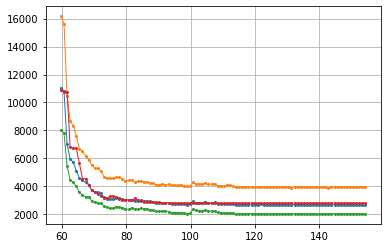

In [28]:
fig=plt.figure(figsize=(6,4))
ax=plt.subplot(111)
ax.grid()

results = optimization_results.query("problem=='BPBC' and percentile.isnull()").sort_values(by='constraint')
constraint_list = results['constraint'].to_list()
result_list = results['duration_avg'].to_list()
ax.plot(constraint_list, result_list, marker='o', label='Without BCR', markersize=2, linewidth=1)
result_list = results['duration_percentile90'].to_list()
ax.plot(constraint_list, result_list, marker='o', label='Without BCR', markersize=2, linewidth=1)
result_list = results['duration_percentile10'].to_list()
ax.plot(constraint_list, result_list, marker='o', label='Without BCR', markersize=2, linewidth=1)
ax.plot(constraint_list, App6_BPBC_PRCP['Best_Answer_RT'], marker='o', label='Without BCR', markersize=2, linewidth=1)
# ax.plot(opt_curve_data_BPBC['Budget'], opt_curve_data_BPBC['BCR_MAX_RT'], marker='o', label='BCR MAX', markersize=2, linewidth=1) 
# ax.plot(opt_curve_data_BPBC['Budget'], opt_curve_data_BPBC['BCR_ERT/C_RT'], marker='o', label='BCR ERT/C', markersize=2, linewidth=1)
# ax.plot(opt_curve_data_BPBC['Budget'], opt_curve_data_BPBC['BCR_RT/M_RT'], marker='o', label='BCR RT/M', markersize=2, linewidth=1)  
# ax.plot(opt_curve_data_BPBC['Budget'], opt_curve_data_BPBC['Best_Answer_RT'] , marker='o', label='Best Answer', markersize=2, linewidth=1) 
# ax.plot(opt_curve_data_BPBC['Budget'], best_rt, marker='o', label='Ideal BPBC Solution', markersize=2, linewidth=1) 
# ax.legend(loc='upper right', bbox_to_anchor=(1,0.86))
# ax.set_xlabel('Budget Constraint in USD (per 1 Million Executions)')
# ax.set_ylabel('End-to-end Response time in ms')
# ax.set_ylim(2500,6500)
# ax2 = ax.twinx()
# ax2.plot(opt_curve_data_BPBC['Budget'], BPBC_accuracy, marker = 'x', label='Accuracy', color='magenta')
# ax2.legend(loc='upper right', bbox_to_anchor=(1,0.96))
# ax2.set_ylim(0,100)
# ax2.set_ylabel('Accuracy in Percentage')
# fig.savefig('Optimization_Curve_BPBC', dpi=300)
fig.savefig('Optimization_Curve_BPBC.pdf')
# print('Average Accuracy: ',BPBC_accuracy.mean())

In [29]:
results.to_csv("BPBC_avg.csv", index=False)

### BCPC

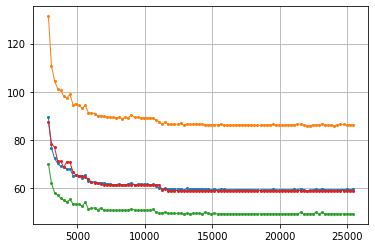

In [30]:
fig=plt.figure(figsize=(6,4))
ax=plt.subplot(111)
ax.grid()

results = optimization_results.query("problem=='BCPC' and percentile.isnull()").sort_values(by='constraint')
constraint_list = results['constraint'].to_list()
result_list = results['cost_avg'].to_list()
ax.plot(constraint_list, result_list, marker='o', label='Without BCR', markersize=2, linewidth=1)
result_list = results['cost_percentile90'].to_list()
ax.plot(constraint_list, result_list, marker='o', label='Without BCR', markersize=2, linewidth=1)
result_list = results['cost_percentile10'].to_list()
ax.plot(constraint_list, result_list, marker='o', label='Without BCR', markersize=2, linewidth=1)
ax.plot(constraint_list, App6_BCPC_PRCP['Best_Answer_Cost'], marker='o', label='Without BCR', markersize=2, linewidth=1)
fig.savefig('Optimization_Curve_BCPC.pdf')

In [31]:
results.to_csv("BCPC_avg.csv", index=False)

### Accuracy

In [32]:
results = optimization_results.query("problem=='BPBC' and percentile.isnull()").sort_values(by='constraint')
result_list = results['duration_avg']
accuracy = (np.array(result_list) - np.array(best_rt))/np.array(best_rt).tolist()
accuracy = [num * 100 if num > 0 else 0 for num in accuracy]
accuracy = [0 if num < 1 else num for num in accuracy]
BPBC_accuracy = [100 - num for num in accuracy]
np.mean(BPBC_accuracy)

99.0886138652194

In [33]:
results = optimization_results.query("problem=='BCPC' and percentile.isnull()").sort_values(by='constraint')
result_list = results['cost_avg']
accuracy = (np.array(result_list) - np.array(best_cost))/np.array(best_cost).tolist()
accuracy = [num * 100 if num > 0 else 0 for num in accuracy]
accuracy = [0 if num < 1 else num for num in accuracy]
BCPC_accuracy = [100 - num for num in accuracy]
np.mean(BCPC_accuracy)

99.74424843610724

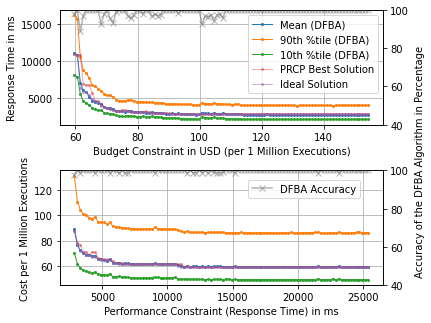

In [141]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 4.6))
ax1.grid()

results = optimization_results.query("problem=='BPBC' and percentile.isnull()").sort_values(by='constraint')
constraint_list = results['constraint'].to_list()
result_list = results['duration_avg'].to_list()
ax1.plot(constraint_list, result_list, marker='o', label='Mean (DFBA)', markersize=2, linewidth=1)
result_list = results['duration_percentile90'].to_list()
ax1.plot(constraint_list, result_list, marker='o', label='90th %tile (DFBA)', markersize=2, linewidth=1)
result_list = results['duration_percentile10'].to_list()
ax1.plot(constraint_list, result_list, marker='o', label='10th %tile (DFBA)', markersize=2, linewidth=1)
ax1.plot(constraint_list, App6_BPBC_PRCP['Best_Answer_RT'], marker='o', label='PRCP Best Solution', markersize=2, linewidth=1, alpha=0.4)
ax1.plot(constraint_list, best_rt, marker='o', label='Ideal Solution', markersize=2, linewidth=1, alpha=0.5)
ax1_twin = ax1.twinx()
ax1_twin.plot(constraint_list, BPBC_accuracy, marker = 'x', label='DFBA Accuracy', color='grey', alpha=0.6)
ax1_twin.set_ylim(40, 100)
ax1.legend()
# ax1_twin.legend()
# ax1_twin.legend(loc='upper right', bbox_to_anchor=(0.945, 0.37))
ax1.set_xlabel("Budget Constraint in USD (per 1 Million Executions)")
ax1.set_ylabel("Response Time in ms")
ax2.grid()

results = optimization_results.query("problem=='BCPC' and percentile.isnull()").sort_values(by='constraint')
constraint_list = results['constraint'].to_list()
result_list = results['cost_avg'].to_list()
ax2.plot(constraint_list, result_list, marker='o', label='Mean', markersize=2, linewidth=1)
result_list = results['cost_percentile90'].to_list()
ax2.plot(constraint_list, result_list, marker='o', label='90-th Percentile', markersize=2, linewidth=1)
result_list = results['cost_percentile10'].to_list()
ax2.plot(constraint_list, result_list, marker='o', label='10-th Percentile', markersize=2, linewidth=1)
ax2.plot(constraint_list, App6_BCPC_PRCP['Best_Answer_Cost'], marker='o', label='PRCP Best Solution', markersize=2, linewidth=1, alpha=0.4)
ax2.plot(constraint_list, best_cost, marker='o', label='Ideal Solution', markersize=2, linewidth=1, alpha=0.5)
ax2_twin = ax2.twinx()
ax2_twin.plot(constraint_list, BCPC_accuracy, marker = 'x', label='DFBA Accuracy', color='grey', alpha=0.6)
ax2_twin.legend(loc='upper right', bbox_to_anchor=(0.945, 0.96))
ax2_twin.set_ylim(40, 100)
ax2.set_xlabel("Performance Constraint (Response Time) in ms")
ax2.set_ylabel("Cost per 1 Million Executions")

fig.text(0.98, 0.5, 'Accuracy of the DFBA Algorithm in Percentage', va='center', ha='center', rotation='vertical')

fig.tight_layout(rect=[0, 0, 0.98, 1])
plt.show()
fig.savefig("DFBA-PRCP.pdf")